# Gender classification of reddit authors
Andrea Pio Maria Cota, matricola: 866282

In [1]:
%pylab inline
# Pandas per analisi e manipolazione dati
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Data observation

train_data è di dimensione (296'042 X 4), in cui ogni riga corrisponde a un post di un utente in un subreddit e le 4 colonne sono: author, subreddit, UTC e body

In [2]:
train_data = pd.read_csv("train_data.csv", encoding="utf8")
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


I commenti nel dataset a disposizione sono 296042 ma gli autori sono 5000, il chè sta a significare che ogni autore può aver scritto in più di un subreddit

In [3]:
train_data.author.unique().shape

(5000,)

Target è invece di dimensione 5000 x 2, con le due colonne che sono author e gender, dove gli utenti maschi sono rappresentati con 0 mentre gli utenti femmine con 1

In [4]:
target = pd.read_csv("train_target.csv")
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature extraction

Definisco subreddits_map come una serie di Pandas che ha come indici i subreddit (unici) e come valori dei numeri compresi tra 0 e il numero di subreddit unici

In [6]:
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=arange(subreddits.shape[0]))

mylittlepony            0
sex                     1
DragonsDogma            2
malefashionadvice       3
todayilearned           4
                     ... 
palegirls            3463
onions               3464
mumfordandsons       3465
infertility          3466
HangoutFest          3467
Length: 3468, dtype: int64

In [41]:
# Pacchetto matrice sparsa per dati numerici
from scipy import sparse

Definisco una funzione che crea una matrice sparsa. Dato un autore questa matrice avrà dimensione 1 X 3468, in cui ogni colonna è un subreddit e per ogni subreddit il valore della matrice è 0 se l'autore non ha scritto in quel subreddit e 1 se l'ha fatto.

In [42]:
def extract_features(group):
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values
    idxs = subreddits_map.loc[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
    return v.tocsr()

Ad esempio per l'autore "RedThunder90" si osserva come ha scritto in un solo subreddit

In [43]:
extract_features(train_data[train_data.author=='RedThunder90'])

<1x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

Definisco features_dict come un dizionario contente per ogni autore la matrice sparsa definita poco prima:

In [44]:
features_dict = {}

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

A questo punto creo la matrice X con un vertical stack delle componenti del dizionario features_dict:

In [45]:
X = sparse.vstack([features_dict[author] for author in target.author])
X

<5000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 49152 stored elements in Compressed Sparse Row format>

Nota: avendo riempito questa matrice con un for relativo a target.author, essa risulta avere gli autori nello stesso ordine con cui appaiono in target, risolvendo così il problema degli ordini diversi, in quanto originariamente l'ordine degli autori nei due dataset era diverso

Assegno alla variabile y il gender degli autori

In [46]:
y = target.gender

Definisco la funzione extract_text che, dato un autore, mette insieme in un'unica stringa tutti  i commenti scritti da quell'autore:

In [47]:
def extract_text(group):
    group_text = group['body'].values
    return " ".join(group_text)

extract_text(train_data[train_data.author=='RedThunder90'])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

Creo il dizionario text_dict che raccoglie per ogni autore il risultato di extract_text per quell'autore:

In [48]:
text_dict = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

Creo author_text, ordinato con l'ordine degli autori in target:

In [49]:
author_text = [text_dict[author] for author in target.author]

Per utilizzare, oltre ai subreddit, anche quello che l'utente scrive è necessario trasformare il testo in features vectors. La tecnica che ho usato è quella del Term Frequency-Inverse Document Frequency:

In [50]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #per eliminare parole comuni

pattern ='(?u)\\b[A-Za-z]{3,}' #cerchiamo parole con un minimo di 3 caratteri tra A-Za-z

stop_words = set(list(ENGLISH_STOP_WORDS)) #per non conteggiare tutte le parole (quelle molto comuni)

# cv implementa sia la parte di separazione delle parole che di conteggio
cv = CountVectorizer(token_pattern=pattern, stop_words=stop_words, max_features=10000)
# per ottimizzare metto un limite di parole in cv, si tratta di una scelta arbitraria

C = cv.fit_transform(author_text) # è la matrice del conteggio delle parole

tfidf = TfidfTransformer() # applichiamo normalizzazione

# Otteniamo così la matrice delle tf-idf features
X_tfidf = tfidf.fit_transform(C)
X_tfidf

<5000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 1713288 stored elements in Compressed Sparse Row format>

A questo punto ottengo un'unica matrice X_train che uso per fare learning:

In [51]:
from scipy.sparse import hstack
X_train = hstack((X, X_tfidf))

Al termine di questa parte di features extraction ho la matrice X_train di dimensione (5000 X 13468). I componenti di questa matrice sono:
- X che contiene l'informazione sui subreddits in cui ciascun autore ha scritto 
- X_tfidf che contiene l'informazione sulle parole più usate da ciasun autore

# Model selection

Come primo approccio al problema ho deciso di utilizzare soltanto l'informazione sui subreddit per osservare un primo score e vedere come poi sarebbe cambiato usando anche l'informazione relativa al testo.
Il modello che ho deciso di utilizzare inizialmente è una Logistic regression:

LOGISTIC REGRESSION

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression ()
lr.fit(X,y)

LogisticRegression()

In [16]:
y_pred_lr = lr.predict_proba(X_test)[:,1]
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred_lr})
solution.head()

,author,gender
0,ejchristian86,0.999976
1,ZenDragon,0.002713
2,savoytruffle,0.018238
3,hentercenter,0.059859
4,rick-o-suave,0.304228


Score ottenuto: 0.89911

Qui, invece, inizia la vera parte di model selection che fa utilizzo anche dell'informazione relativa ai commenti degli autori.
La soluzione che ho deciso di presentare vede come modello il "MULTINOMIAL NAIVE-BAYES":

In [52]:
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

#Creo una lista di valori per il parametro alfa di regolarizzazione che va da 10^{-4} a 10^{10} spaziati in scala log
alphas = np.logspace(-4, 10, 1000)
scores = []

for alpha in alphas:
    model.alpha = alpha
    scores_alpha = model_selection.cross_val_score(model, X_train, y, cv=10) # processo viene eseguito 10 volte, e ridà 10 valori diversi per ognugna delle parti valutate
    scores.append(np.mean(scores_alpha))

Best alpha: 0.3746050032748993
Best score: 0.8705999999999999


Text(0,0.5,'Score (accuracy)')

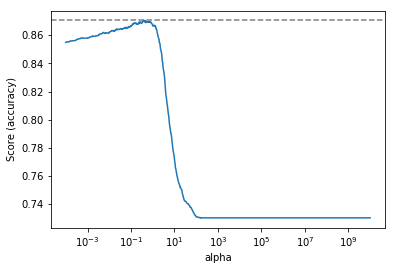

In [53]:
print ('Best alpha:', alphas[np.argmax(scores)])
print ('Best score:', scores[np.argmax(scores)])
axhline(np.max(scores), linestyle='--', color='.5')

plt.semilogx(alphas, scores)
plt.xlabel('alpha')
plt.ylabel('Score (accuracy)')

si noti come man mano, a sinistra del massimo, l'algoritmo sta imparando mentre a destra del massimo ho underfitting

In [54]:
model = MultinomialNB(alpha = 0.3746050032748993)
model.fit(X_train,y)

MultinomialNB(alpha=0.3746050032748993)

# Preparing the solution

Carico i dati di test

In [55]:
test_data = pd.read_csv("test_data.csv", encoding="utf8")

Rifaccio le stesse operazioni fatte per la parte di training

In [56]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

A questo punto creo la matrice X_test con un vertical stack delle componenti del dizionario features_dict:

In [57]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
X_test

<15000x3468 sparse matrix of type '<class 'numpy.float64'>'
	with 144898 stored elements in Compressed Sparse Row format>

In [58]:
def extract_text_test(group):
    group_text = group['body'].values
    return "".join(str(group_text))

Creo il dizionario text_dict_test che raccoglie per ogni autore il risultato di extract_text per quell'autore:

In [59]:
text_dict_test = {}

for author, group in test_data.groupby('author'):
    text_dict_test[author] = extract_text_test(group)

Creo author_text_test, ordinato con l'ordine degli autori in target:

In [60]:
author_text_test = [text_dict_test[author] for author in test_data.author.unique()]

Applico tf-idf:

In [61]:
C_test1 = cv.transform(author_text_test)
X_test1 = tfidf.transform(C_test1)

Creo la matrice contenente sia l'info sul subreddit che sul body

In [62]:
X_final = hstack((X_test, X_test1))
X_final

<15000x13468 sparse matrix of type '<class 'numpy.float64'>'
	with 5038229 stored elements in COOrdinate format>

Ottenendo la predizione del modello:

In [63]:
y_pred = model.predict_proba(X_final)[:,1]

In [64]:
solution = pd.DataFrame({"author":test_data.author.unique(), "gender":y_pred})
solution.head()

,author,gender
0,ejchristian86,1.000000e+00
1,ZenDragon,6.659747e-12
2,savoytruffle,3.329350e-05
3,hentercenter,1.350938e-04
4,rick-o-suave,4.851008e-02


Score ottenuto: 0.92201

In [65]:
solution.to_csv("BestSolution2.csv", index=False)